<a href="https://colab.research.google.com/github/BlackLutos/Machine_Learing_lab3/blob/main/%5BMediaTek_IEE5725%5D_Machine_Learning_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab#3 From Training to Deployment


---



# Copy the dataset from Gdrive to Colab

In [ ]:
!cp -rf drive/MyDrive/MediaTek_IEE5725_Machine_Learning_Lab3/

cp: missing destination file operand after 'drive/MyDrive/MediaTek_IEE5725_Machine_Learning_Lab3/'
Try 'cp --help' for more information.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install tensorflow-gpu==1.15

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Unzip your dataset



In [4]:
!zip -s- /content/drive/MyDrive/MediaTek_IEE5725_Machine_Learning_Lab3/ICME2022_Training_Dataset.zip -O /content/drive/MyDrive/MediaTek_IEE5725_Machine_Learning_Lab3/COMBINED_FILE.zip
!unzip /content/drive/MyDrive/MediaTek_IEE5725_Machine_Learning_Lab3/COMBINED_FILE.zip -d /content/drive/MyDrive/MediaTek_IEE5725_Machine_Learning_Lab3/

串流輸出內容已截斷至最後 5000 行。
  inflating: /content/drive/MyDrive/MediaTek_IEE5725_Machine_Learning_Lab3/ICME2022_Training_Dataset/labels/color_labels/0b36ee90-f89cd13d_lane_line_color.png  
  inflating: /content/drive/MyDrive/MediaTek_IEE5725_Machine_Learning_Lab3/ICME2022_Training_Dataset/labels/color_labels/47a22471-44229044_lane_line_color.png  
  inflating: /content/drive/MyDrive/MediaTek_IEE5725_Machine_Learning_Lab3/ICME2022_Training_Dataset/labels/color_labels/29885f13-71891baf_lane_line_color.png  
  inflating: /content/drive/MyDrive/MediaTek_IEE5725_Machine_Learning_Lab3/ICME2022_Training_Dataset/labels/color_labels/696b91dc-be06f63e_lane_line_color.png  
  inflating: /content/drive/MyDrive/MediaTek_IEE5725_Machine_Learning_Lab3/ICME2022_Training_Dataset/labels/color_labels/5a8f9b5d-1fdfd2d4_lane_line_color.png  
  inflating: /content/drive/MyDrive/MediaTek_IEE5725_Machine_Learning_Lab3/ICME2022_Training_Dataset/labels/color_labels/7230963a-f0c5a683_lane_line_color.png  
  inflating: 

In [5]:
import cv2
import matplotlib.pyplot as plt
import random
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import glob
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import tensorflow as tf

from pathlib import Path
from tensorflow.python.framework.graph_util import convert_variables_to_constants

In [6]:
print("Tensorflow Version is %s" % tf.__version__)

Tensorflow Version is 1.15.0


# Data Process

In [7]:
class DataLoaderSegmentation(data.Dataset):
    def __init__(self, input_path,label_path,label_name='',transform=None):
        super(DataLoaderSegmentation, self).__init__()
        self.img_files = glob.glob(os.path.join(input_path,'*.jpg'))
        self.mask_files = []
        self.transforms = transform
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(label_path,os.path.basename(img_path).split('.')[0]+label_name+'.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path)
            label = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
            label = F.one_hot(torch.from_numpy(label).to(torch.int64),6)
            datalabel = np.concatenate((data,label),axis=2)
            datalabel = np.transpose(datalabel,[2,0,1])
            if self.transforms!=None:
              datalabel = self.transforms(torch.from_numpy(datalabel).float())
            datalabel = np.transpose(datalabel,[1,2,0])
            data = datalabel[:,:,0:3]
            label = datalabel[:,:,3:9]
            return data,label

    def __len__(self):
        return len(self.img_files)

# Prepare Training dataset

In [8]:
input_path='/content/drive/MyDrive/MediaTek_IEE5725_Machine_Learning_Lab3/ICME2022_Training_Dataset/images'#720/1280
label_path='/content/drive/MyDrive/MediaTek_IEE5725_Machine_Learning_Lab3/ICME2022_Training_Dataset/labels/class_labels'
dataset = DataLoaderSegmentation(input_path,label_path,'_lane_line_label_id',transforms.Resize(size=(720,1280)))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=25, shuffle=True)

In [9]:
input_path='/content/drive/MyDrive/MediaTek_IEE5725_Machine_Learning_Lab3/ICME2022_Training_Dataset/images_real_world'#1080/1920
label_path='/content/drive/MyDrive/MediaTek_IEE5725_Machine_Learning_Lab3/ICME2022_Training_Dataset/labels_real_world'
dataset_real = DataLoaderSegmentation(input_path,label_path,'',transforms.Resize(size=(1080,1920)))
dataloader_real = torch.utils.data.DataLoader(dataset_real, batch_size=25, shuffle=True)

# FIXME#1 Design the Network
*   input size = 256*256
*   Channel = 15 and Depth = 5
*   backbone: conv2d+BN+Relu
*   output size = 1080*1920





In [10]:
inputs = tf.placeholder(tf.float32,shape=(None,None, None, 3))
y_ = tf.placeholder(tf.float32, [None,None, None,6])
x = tf.image.resize_images(inputs, (256, 256))
x = x/255.0
y = tf.image.resize_images(y_, (256, 256))
ch=13
depth=5
xn = []
b=tf.Variable(0.0)
x=tf.layers.conv2d(x,ch,3,1,'same')
x=tf.layers.batch_normalization(x)
x = tf.nn.relu(x)
for i in range(depth):
  xn.append(x)
  x = tf.layers.conv2d(x,ch*(2**(i+1)),3,1,'same')
  x = tf.layers.batch_normalization(x,center=False,scale=False)+b
  x = tf.nn.relu(x)
  x = tf.layers.conv2d(x,ch*(2**(i+1)),3,1,'same')
  x = tf.layers.batch_normalization(x,center=False,scale=False)+b
  x = tf.nn.relu(x)
  if i <depth-1:
    x = tf.nn.avg_pool(x,[1,2,2,1],[1,2,2,1],'SAME')
for i in range(depth):
  if i>0:
    x = tf.keras.layers.UpSampling2D((2,2))(x)
  x = tf.layers.conv2d(x,ch*(2**(depth-i-1)),3,1,'same')+xn[-i-1]
  x = tf.layers.batch_normalization(x,center=False,scale=False)+b
  x = tf.nn.relu(x)
out = tf.layers.conv2d(x,6,3,1,'same')
outputs = out
outputs = tf.image.resize_images(outputs, (1080, 1920))
outputs = tf.argmax(outputs,-1)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


# Set up the Hyper parameters

In [11]:
loss=tf.nn.softmax_cross_entropy_with_logits_v2(logits=out,labels=y)
loss=tf.reduce_mean(loss)
optimizer = tf.train.AdamOptimizer(learning_rate = 0.00001)
train = optimizer.minimize(loss+0.0005*b)
saver=tf.train.Saver()
init = tf.global_variables_initializer()

# Sesstion run and restore Checkpoint

In [12]:
sess = tf.Session()
sess.run(init)
saver.restore(sess, '/content/drive/MyDrive/MediaTek_IEE5725_Machine_Learning_Lab3/model/')

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/MediaTek_IEE5725_Machine_Learning_Lab3/model/


# Model Profiling to get Flops and #Parameters

In [13]:
def stats_graph(graph):
  flops = tf.profiler.profile(graph, options=tf.profiler.ProfileOptionBuilder.float_operation())
  params = tf.profiler.profile(graph, options=tf.profiler.ProfileOptionBuilder.trainable_variables_parameter())
  print('FLOPs: {}; Trainable params:{}'.format(flops.total_float_ops, params.total_parameters))
stats_graph(tf.get_default_graph())

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


145 ops no flops stats due to incomplete shapes.
145 ops no flops stats due to incomplete shapes.


FLOPs: 8300731; Trainable params:4152402


# Set training Epochs, Print the training logs and Save your Checkpoint

In [14]:
num_epochs = 1
for epoch in range(num_epochs):
  for i, data in enumerate(dataloader, 0):
    input = data[0].numpy()
    label = data[1].numpy()
    sess.run(train,feed_dict={inputs: input, y_: label})
    if i % 10 == 0:
      print("[%d/%d][%s/%d] loss: %.4f b: %.4f "\
            %(epoch+1, num_epochs, str(i).zfill(4), len(dataloader), sess.run(loss,feed_dict={inputs: input, y_: label}),sess.run(b)) )
    if i%300==0:
      print('checkpoint saved')
      for i, data in enumerate(dataloader_real, 0):
        input = data[0].numpy()
        label = data[1].numpy()
        sess.run(train,feed_dict={inputs: input, y_: label})
      saver.save(sess, 'drive/MyDrive/MediaTek_IEE5725_Machine_Learning_Lab3/model/')
  saver.save(sess, 'drive/MyDrive/MediaTek_IEE5725_Machine_Learning_Lab3/model/')
  print('checkpoint saved')

[1/1][0000/1420] loss: 0.3556 b: 0.0013 
checkpoint saved
[1/1][0010/1420] loss: 0.2860 b: 0.0013 
[1/1][0020/1420] loss: 0.3085 b: 0.0013 
[1/1][0030/1420] loss: 0.3117 b: 0.0013 
[1/1][0040/1420] loss: 0.3163 b: 0.0013 
[1/1][0050/1420] loss: 0.2993 b: 0.0013 
[1/1][0060/1420] loss: 0.3106 b: 0.0013 
[1/1][0070/1420] loss: 0.3098 b: 0.0013 
[1/1][0080/1420] loss: 0.2960 b: 0.0013 
[1/1][0090/1420] loss: 0.3245 b: 0.0013 
[1/1][0100/1420] loss: 0.3099 b: 0.0013 
[1/1][0110/1420] loss: 0.2966 b: 0.0013 
[1/1][0120/1420] loss: 0.2924 b: 0.0013 
[1/1][0130/1420] loss: 0.2928 b: 0.0013 
[1/1][0140/1420] loss: 0.3446 b: 0.0013 
[1/1][0150/1420] loss: 0.3263 b: 0.0013 
[1/1][0160/1420] loss: 0.3061 b: 0.0013 
[1/1][0170/1420] loss: 0.3021 b: 0.0013 
[1/1][0180/1420] loss: 0.2824 b: 0.0013 
[1/1][0190/1420] loss: 0.3098 b: 0.0013 
[1/1][0200/1420] loss: 0.3019 b: 0.0013 
[1/1][0210/1420] loss: 0.3091 b: 0.0013 
[1/1][0220/1420] loss: 0.3141 b: 0.0013 
[1/1][0230/1420] loss: 0.3070 b: 0.0013 

# Save your graph into .pb

In [15]:
graph_def = convert_variables_to_constants(sess, sess.graph_def, output_node_names = ['ArgMax'])
tf.train.write_graph(graph_def, '/content/MediaTek_IEE5725_Machine_Learning_Lab3/', 'lab3_model.pb', as_text = False)

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 69 variables.
INFO:tensorflow:Converted 69 variables to const ops.


'/content/MediaTek_IEE5725_Machine_Learning_Lab3/lab3_model.pb'

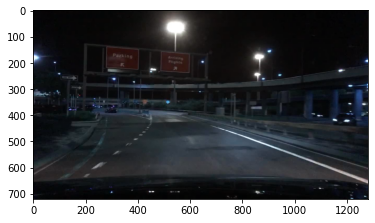

In [16]:
plt.imshow(data[0][0]/255.0)

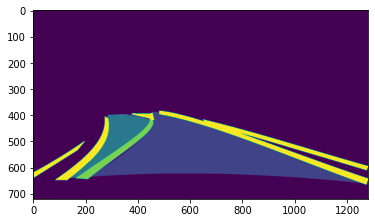

In [17]:
plt.imshow(np.argmax(data[1][0], 2))

# Show your results in different Epochs

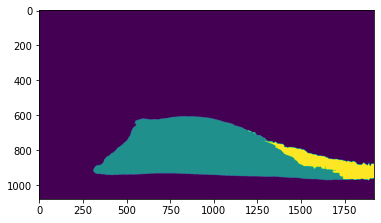

In [18]:
predict=sess.run(outputs,feed_dict={inputs: data[0]})
plt.imshow(predict[0])

In [19]:
sess.close()

# Run your model on real device